# Whisper Fine-tuning for Enenlhet Language (CPU Version)

This notebook fine-tunes OpenAI's Whisper model on Enenlhet audio transcription data using **CPU-only training**. 

In [1]:
import os
import random
import numpy as np
import torch
from datasets import Dataset, load_from_disk, Audio
from transformers import WhisperProcessor, WhisperForConditionalGeneration, WhisperFeatureExtractor, WhisperTokenizer
from dataclasses import dataclass
from typing import Any, Dict, List, Union
import evaluate
from transformers.trainer_seq2seq import Seq2SeqTrainer
from transformers.training_args_seq2seq import Seq2SeqTrainingArguments
from transformers import EarlyStoppingCallback
from codecarbon import EmissionsTracker

In [2]:
if torch.backends.mps.is_available():
    print("⚠️ Disabling MPS backend manually")
    torch.backends.mps.is_built = False
    torch.backends.mps.is_available = lambda: False

⚠️ Disabling MPS backend manually


In [3]:
output_dir = "../whisper_finetune_cpu"
log_dir = "../logs"

# If directories do not exist, create them
os.makedirs(output_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

In [4]:
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "0"  # disables automatic fallback
os.environ["CUDA_VISIBLE_DEVICES"] = ""          # disables CUDA

In [5]:
# Set random seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [6]:
whisper_dataset = load_from_disk("whisper_prepared_dataset")

In [7]:
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")
processor = WhisperProcessor.from_pretrained("openai/whisper-small")
tokenizer = processor.tokenizer
model.generation_config.forced_decoder_ids = None
device = torch.device("cpu")  # Ensure we are using CPU
model.to(device)
print("Model device:", next(model.parameters()).device)


Model device: cpu


In [8]:
@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any
    decoder_start_token_id: int

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.decoder_start_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

data_collator = DataCollatorSpeechSeq2SeqWithPadding(
    processor=processor,
    decoder_start_token_id=model.config.decoder_start_token_id,
)


In [9]:
# Evaluation metric
wer_metric = evaluate.load("wer")

def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # Replace -100s used for padding as we can't decode them
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id

    # Decode predictions and labels
    pred_str = processor.tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = processor.tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    # Compute WER
    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

In [10]:
training_args = Seq2SeqTrainingArguments(
    output_dir=output_dir,
    logging_dir=log_dir,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,
    learning_rate=5e-5,
    warmup_steps=0,
    max_steps=2100,
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    logging_steps=10,
    predict_with_generate=True,
    generation_max_length=225,
    load_best_model_at_end=True,             # ✅ needed for early stopping
    metric_for_best_model="eval_wer",        # ✅ WER is your goal
    greater_is_better=False,                 # ✅ lower WER = better
    fp16=False,
    gradient_checkpointing=False,
    report_to=["tensorboard"],
)


In [11]:
trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=whisper_dataset["train"],
    eval_dataset=whisper_dataset["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    processing_class=processor,
)

In [12]:
tracker = EmissionsTracker(
    project_name="whisper-enenlhet-cpu",
    output_dir=log_dir,
    output_file="whisper-emissions-cpu.csv"
)

[codecarbon INFO @ 23:34:09] [setup] RAM Tracking...
[codecarbon INFO @ 23:34:09] [setup] GPU Tracking...
[codecarbon INFO @ 23:34:09] No GPU found.
[codecarbon INFO @ 23:34:09] [setup] CPU Tracking...
[codecarbon WARNING @ 23:34:09] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 23:34:09] We saw that you have a Apple M4 Pro but we don't know it. Please contact us.
[codecarbon INFO @ 23:34:09] CPU Model on constant consumption mode: Apple M4 Pro
[codecarbon INFO @ 23:34:09] >>> Tracker's metadata:
[codecarbon INFO @ 23:34:09]   Platform system: macOS-15.5-arm64-arm-64bit
[codecarbon INFO @ 23:34:09]   Python version: 3.10.9
[codecarbon INFO @ 23:34:09]   CodeCarbon version: 2.2.2
[codecarbon INFO @ 23:34:09]   Available RAM : 24.000 GB
[codecarbon INFO @ 23:34:09]   CPU count: 12
[codecarbon INFO @ 23:34:09]   CPU model: Apple M4 Pro
[codecarbon INFO @ 23:34:09]   GPU count: None
[codecarbon INFO @ 23:34:09]   GPU model: None


In [13]:
try:
    tracker.start()
    # Train the model
    train_result = trainer.train()
    tracker.stop()
    print("\n🎉 Training completed successfully!")
    print(f"📉 Final training loss: {train_result.training_loss:.4f}")
    print(f"📊 Total training steps: {train_result.global_step}")
    
    # Final evaluation
    print("\n📊 Running final evaluation...")
    eval_result = trainer.evaluate()
    print(f"📈 Final WER: {eval_result['eval_wer']:.4f}")
    
    # Save final model
    print(f"\n💾 Saving final model to {training_args.output_dir}")
    trainer.save_model()
    processor.save_pretrained(training_args.output_dir)
    
    print("✅ Training and saving completed successfully!")
    
except Exception as e:
    print(f"\n❌ Training failed with error: {e}")
    import traceback
    traceback.print_exc()
    
    # Still try to save current model state
    print("💾 Attempting to save current model state...")
    try:
        trainer.save_model()
        processor.save_pretrained(training_args.output_dir)
        print("✅ Model saved despite training error")
    except:
        print("❌ Could not save model")

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss,Validation Loss,Wer
100,3.593400,3.434077,0.995005
200,3.158000,3.113368,0.995005
300,3.002600,2.973043,1.052947
400,2.702800,2.839358,1.034466
500,2.769000,2.769082,0.997003
600,2.777700,2.704933,1.040959
700,2.358200,2.723294,1.059940
800,2.373400,2.679924,1.013986
900,2.414100,2.632710,1.034965
1000,2.489300,2.592106,1.465534


[codecarbon INFO @ 23:34:24] Energy consumed for RAM : 0.000038 kWh. RAM Power : 9.000000000000002 W
[codecarbon INFO @ 23:34:24] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:34:24] 0.000215 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:34:39] Energy consumed for RAM : 0.000075 kWh. RAM Power : 9.000000000000002 W
[codecarbon INFO @ 23:34:39] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:34:39] 0.000429 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:34:54] Energy consumed for RAM : 0.000113 kWh. RAM Power : 9.000000000000002 W
[codecarbon INFO @ 23:34:54] Energy consumed for all CPUs : 0.000532 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:34:54] 0.000644 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:35:09] Energy consumed for RAM : 0.000150 kWh. RAM Power : 9.000000000000002 W
[codecarbon INFO @ 23:35:09] Energy consumed for a


🎉 Training completed successfully!
📉 Final training loss: 2.3205
📊 Total training steps: 2100

📊 Running final evaluation...


📈 Final WER: 0.9875

💾 Saving final model to ../whisper_finetune_cpu
✅ Training and saving completed successfully!


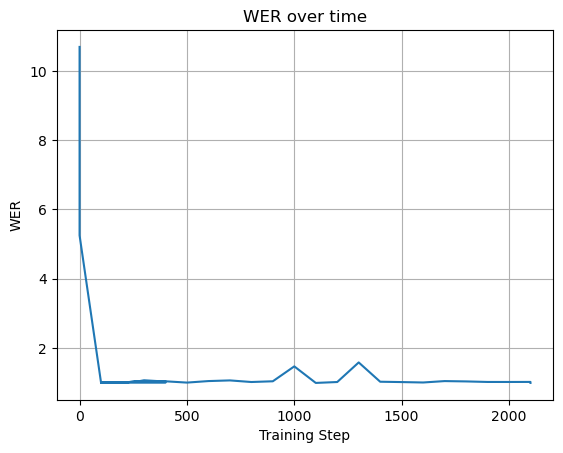

In [14]:
import pandas as pd
from transformers.trainer_utils import get_last_checkpoint

# Load logs from TensorBoard logs (if you've enabled them)
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

event_acc = EventAccumulator(log_dir)  # log_dir from your training_args
event_acc.Reload()

# Get WER logs
wer_events = event_acc.Scalars("eval/wer")
steps = [e.step for e in wer_events]
wers = [e.value for e in wer_events]

# Plot
import matplotlib.pyplot as plt

plt.plot(steps, wers)
plt.xlabel("Training Step")
plt.ylabel("WER")
plt.title("WER over time")
plt.grid(True)
plt.show()
